In [1]:
import pyForwardFolding as pyFF
import pandas as pd
import yaml
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import jax
import scipy

In [2]:
data = pd.read_parquet("../../NNMFit_testdata/src/NNMFit_testdata/data/datasets/Toise_ToyTracks/dataframe.parquet")




In [3]:
ana = pyFF.config.analysis_from_config("test.yaml")
lik = pyFF.likelihood.PoissonLikelihood(ana)

In [4]:
model = ana.expectations["det1"].model
be = ana.expectations["det1"]

In [5]:
model_parameters = {
    "astro_norm": 1.0,
    "astro_index": 2.37,
    "atmo_norm": 1.0,
    "escale": 1.0,
    "esmear": 1.0,
    "delta_gamma": 0.0
}

In [6]:
input_variables = {
    "true_energy": jnp.asarray(data.true_e),
    "log10_reco_energy": jnp.log10(jnp.asarray(data.reco_e)),
    "cos_reco_zenith": jnp.cos(jnp.asarray(data.reco_zenith)),
    "baseline_weight": jnp.asarray(data.fluxless_weight),
    "conv_weight": jnp.asarray(data.weight_honda2006),
    "e_scaling": jnp.asarray(data.e_scaling),
    "e_smearing": jnp.asarray(data.e_smearing),
    "summary_stat": jnp.log10(jnp.asarray(data.reco_e))
}

In [7]:
ana.exposed_parameters()

{'powerlaw': {'flux_norm': 'astro_norm', 'spectral_index': 'astro_index'},
 'snowstorm_escale': {'scale': 'escale'},
 'snowstorm_esmear': {'scale': 'esmear'},
 'atmo_norm': {'flux_norm': 'atmo_norm'},
 'delta_gamma': {'delta_gamma': 'delta_gamma'}}

In [8]:
ana.required_variables()

{'cos_reco_zenith',
 'e_scaling',
 'e_smearing',
 'log10_reco_energy',
 'true_energy'}

In [9]:
[(f.name, f.required_variables) for f in ana.expectations["det1"].model.components[1].factors]

[('atmo_norm', []),
 ('delta_gamma', ['true_energy']),
 ('snowstorm_escale', ['e_scaling']),
 ('snowstorm_esmear', ['e_smearing'])]

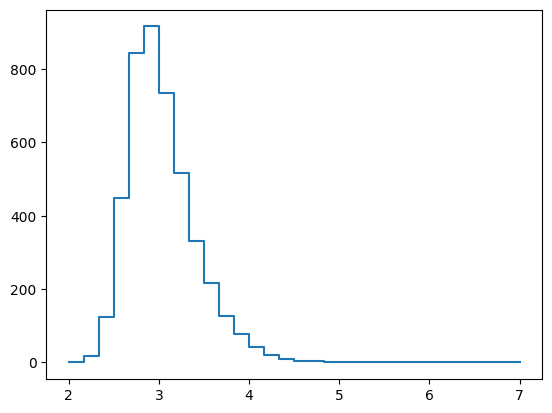

In [12]:
dataset = {"det1": input_variables}
pred = ana.evaluate(dataset, model_parameters)[0]
hsum = pred["det1"].sum(axis=1)
plt.step(be.binning.bin_edges[0], jnp.append(hsum, hsum[-1]))


In [13]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
key = jax.random.PRNGKey(0)
obs = {}
for k, v in hist.items():
    key, subkey = jax.random.split(key)
    obs[k] = jax.random.poisson(subkey, v)
obs = hist # asimov

In [14]:
lh = lik.llh(obs, dataset, model_parameters)
lh_jit = jax.jit(lik.llh)


In [15]:
def eval_for_par(par_val, par_dict):
    par_dict["escale"]= par_val
    lh = lik.llh(obs, dataset, par_dict)
    return lh

val_grad = jax.jit(jax.value_and_grad(eval_for_par, 0) )


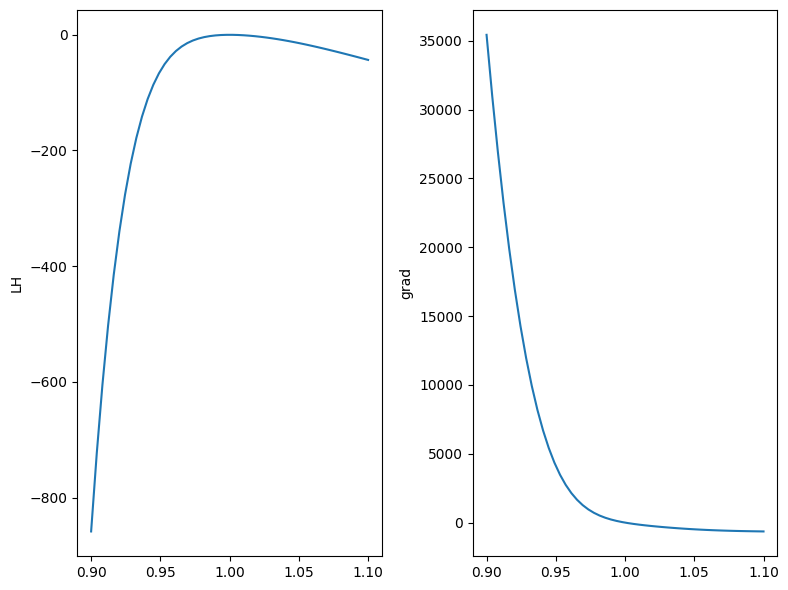

In [16]:
scan_vals = jnp.linspace(0.9, 1.1, 50)
lhs, grads = jax.vmap(val_grad, in_axes=(0, None))(scan_vals, model_parameters)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
ax1.plot(scan_vals, lhs)
ax1.set_ylabel("LH")
ax2.plot(scan_vals, grads)
ax2.set_ylabel("grad")
plt.tight_layout()

In [12]:
wrapped_lh = pyFF.minimizer.WrappedLLH(lik, obs, dataset, {})

In [13]:
pyFF.minimizer.flat_index_dict_mapping(ana.exposed_variables(), {})

{'powerlaw': {'flux_norm': 0, 'spectral_index': 1},
 'snowstorm_escale': {'sys_value': 2},
 'snowstorm_esmear': {'sys_value': 3},
 'atmo_norm': {'flux_norm': 4},
 'delta_gamma': {'delta_gamma': 5}}

In [22]:
fmin_and_grad = jax.jit(jax.value_and_grad(wrapped_lh))

In [49]:
import scipy.optimize

astro_scan = np.linspace(0, 3, 100)

scan_res = []

for astro in astro_scan:

    bounds = scipy.optimize.Bounds(
        [astro,      1.0, 0.9, 0.9, 0,      -1],
        [astro,      4.0, 1.1, 1.1, np.inf,  1]
    )

    res = scipy.optimize.minimize(fmin_and_grad, [1.001, 2.37, 1., 1., 1., 0.01], bounds=bounds, jac=True, method="L-BFGS-B", tol=10)
    scan_res.append(res.fun)

bounds = scipy.optimize.Bounds(
        [0,      1.0, 0.9, 0.9, 0,      -1],
        [np.inf,      4.0, 1.1, 1.1, np.inf,  1]
    )

free_fit = scipy.optimize.minimize(fmin_and_grad, [1.001, 2.37, 1., 1., 1., 0.01], bounds=bounds, jac=True, method="L-BFGS-B", tol=10)

Text(0, 0.5, 'Test Statistic')

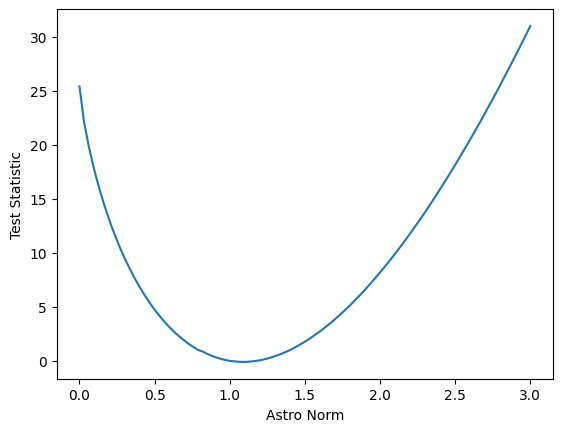

In [52]:
plt.plot(astro_scan, 2*(np.asarray(scan_res) - free_fit.fun))
plt.xlabel("Astro Norm")
plt.ylabel("Test Statistic")

In [3]:
from flax import linen as nn
#from flax.metrics import tensorboard
from flax.training import train_state
import jax
import jax.numpy as jnp
import numpy as np
import optax

class MLP(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        x = nn.sigmoid(x)
        return x
  
class TrainState(train_state.TrainState):
    pass

def create_train_state(module, rng, learning_rate):
    """Creates an initial `TrainState`."""

    params = module.init(rng, jnp.ones([1, 2]))['params'] # initialize parameters by passing a template image
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=module.apply, params=params, tx=tx,
    )

In [4]:
plf = pyFF.factor.PowerLawFlux("powerlaw", 1E5, 1E-18)
atmo_norm = pyFF.factor.FluxNorm("atmo_norm")
snowstorm_escale = pyFF.factor.SnowstormGauss("snowstorm_escale", 0.05, (0.9, 1.1), "e_scaling")
snowstorm_esmear = pyFF.factor.SnowstormGauss("snowstorm_esmear", 0.05, (0.9, 1.1), "e_smearing")
delta_gamma = pyFF.factor.DeltaGamma("delta_gamma", 2617.3148996675773)

atmo = pyFF.model_component.ModelComponent("atmo", [atmo_norm, delta_gamma, snowstorm_escale, snowstorm_esmear])
astro = pyFF.model_component.ModelComponent("astro", [plf, snowstorm_escale, snowstorm_esmear])

model_astro = pyFF.model.Model.from_pairs(
    "model_astro",
    [
        ("baseline_weight", astro)
    ],
)

model_atmo = pyFF.model.Model.from_pairs(
    "model_atmo",
    [
        ("conv_weight", atmo),
    ],
)

binning = pyFF.binning.RelaxedBinning("summary_stat", np.linspace(0, 1, 51), 0.001)

atmo_expec = pyFF.binned_expectation.BinnedExpectation(
    model_atmo,
    binning,
    [])

astro_expec = pyFF.binned_expectation.BinnedExpectation(
    model_astro,
    binning,
    [])

ana = pyFF.analysis.Analysis(
    {"atmo": atmo_expec, "astro": astro_expec})


In [5]:
model_parameters = {
    "powerlaw": {"flux_norm": 1.0, "spectral_index": 2.37},
    "atmo_norm": {"flux_norm": 1.0},
    "snowstorm_escale": {"sys_value": 1.0},
    "snowstorm_esmear": {"sys_value": 1.0},
    "delta_gamma": {"delta_gamma": 0.0}
}
input_variables = {
    "true_energy": jnp.asarray(data.true_e),
    "log10_reco_energy": jnp.log10(jnp.asarray(data.reco_e)),
    "cos_reco_zenith": jnp.cos(jnp.asarray(data.reco_zenith)),
    "baseline_weight": jnp.asarray(data.fluxless_weight),
    "conv_weight": jnp.asarray(data.weight_honda2006),
    "e_scaling": jnp.asarray(data.e_scaling),
    "e_smearing": jnp.asarray(data.e_smearing),
    "summary_stat": jnp.log10(jnp.asarray(data.reco_e))
}
dataset = {"astro": input_variables, "atmo": input_variables}
ana.evaluate(dataset, model_parameters)

({'atmo': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32),
  'astro': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)},
 {'atmo': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32),
  'astro': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
key1, key2 = jax.random.split(jax.random.key(0), 2)
x = jax.random.uniform(key1, (512, 2 ))

# provide key and fake input to get initialized variables

mlp = MLP()

init_variables = mlp.init(key2, x)


Array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 50., 50.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],      dtype=float32)

In [21]:
@jax.jit
def train_step(state, input_variables):
    """Train for a single step."""
    
    def loss_fn(params):

        nn_in = jnp.vstack([
            input_variables["log10_reco_energy"],
            input_variables["cos_reco_zenith"],]).T

        summary_stat = state.apply_fn({"params": params}, nn_in)[:, 0]

        input_variables["summary_stat"] = summary_stat
        dataset = {"astro": input_variables, "atmo": input_variables}
        hist, hist_ssq = ana.evaluate(dataset, model_parameters)

        non_zero = hist["atmo"] > 0

        hatmo_sane = jnp.where(~non_zero, 1, hist["atmo"])

        ts = -jnp.sum(jnp.where(non_zero, hist["astro"] / hatmo_sane, 0))

        return ts

    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [22]:
init_rng = jax.random.key(0)
mlp = MLP()
state = create_train_state(mlp, init_rng, 0.00001)
nn_in = jnp.vstack([
            input_variables["log10_reco_energy"],
            input_variables["cos_reco_zenith"],]).T
state.apply_fn({"params": state.params}, nn_in)[:, 0]

Array([0.6213018 , 0.61393225, 0.608756  , ..., 0.6911311 , 0.68742764,
       0.6877018 ], dtype=float32)

In [23]:
state = train_step(state, input_variables)

UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float32[98834] wrapped in a JVPTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

In [9]:
state

TrainState(step=Array(1, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of MLP()>, params={'Dense_0': {'bias': Array([ 0., nan,  0.,  0., nan, nan, nan, nan, nan, nan,  0., nan, nan,
       nan, nan,  0.,  0.,  0.,  0., nan, nan,  0.,  0.,  0.,  0.,  0.,
       nan,  0., nan, nan, nan,  0., nan, nan, nan, nan, nan,  0., nan,
       nan, nan, nan, nan, nan, nan, nan, nan,  0., nan,  0.,  0., nan,
       nan, nan, nan, nan,  0., nan, nan,  0.,  0., nan,  0.,  0., nan,
       nan, nan, nan, nan,  0.,  0., nan, nan, nan,  0.,  0.,  0.,  0.,
        0., nan, nan, nan, nan,  0.,  0.,  0., nan,  0., nan, nan,  0.,
       nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0., nan, nan,
       nan, nan, nan, nan,  0., nan, nan,  0.,  0.,  0., nan, nan,  0.,
        0., nan,  0.,  0.,  0., nan,  0.,  0., nan,  0., nan],      dtype=float32), 'kernel': Array([[-1.1679986 ,         nan, -0.97421646, -0.60247123,         nan,
                nan,         nan,         nan,         

In [76]:
nn_in = jnp.vstack([
            input_variables["log10_reco_energy"],
            input_variables["cos_reco_zenith"],]).T
state.apply_fn({"params": state.params}, nn_in)[:, 0]

Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)